### Packages

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import datetime

from matrixprofile import *
from matplotlib import pyplot as plt
from fbprophet import Prophet

In [2]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    dataframe.columns = ['ds','y']
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

In [3]:
df = pd.read_csv("./raw data/solar_data-2017.csv")
#df = df.iloc[:, 2:-1]
df = df.iloc[:, 1:-1]
df['TIMESTAMP'] = df['TIMESTAMP'].str.slice(0,19)
df = df.astype({'TIMESTAMP':'datetime64'})
# data slice
#df.set_index('TIMESTAMP', inplace = True)
#df['2017-01-01 00:00:00':'2017-01-30 23:59:59']
df = df.loc[(df.TIMESTAMP <= '2017-01-02 00:00:00') & (df.TIMESTAMP >= '2017-01-01 00:00:00')]
# remove point anomalies (If an individual data instance can be considered as anomalous with respect to the rest of the data)
#df = df.loc[df['InvPDC_kW_Avg'] >= -max(df['InvPDC_kW_Avg'])]
#df = df[~['']]
#df = df.dropna()
df = df.iloc[:, [0, 4]]
#df

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 1440
Data columns (total 2 columns):
TIMESTAMP        1441 non-null datetime64[ns]
InvPDC_kW_Avg    1441 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.8 KB


In [5]:
a = df['InvPDC_kW_Avg'].to_numpy()
#df = df.set_index('TIMESTAMP').sort_index()
#a = df.values.squeeze()
mp = matrixProfile.stomp(a, 4)
mp

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning:

invalid value encountered in sqrt

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\matrixProfile.py:249: RuntimeWarning:

invalid value encountered in less

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning:

invalid value encountered in true_divide

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:126: RuntimeWarning:

invalid value encountered in sqrt

C:\ProgramData\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning:

divide by zero encountered in true_divide



(array([nan, nan, nan, ..., nan, nan, nan]),
 array([inf, inf, inf, ..., inf, inf, inf]))

In [6]:
profile = np.append(mp[0], np.zeros(3) + np.nan)
profile_index = np.append(profile[1], np.zeros(3) + np.nan)

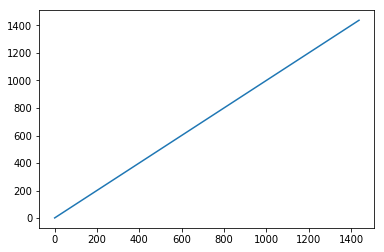

In [7]:
N = np.arange(1,len(mp[0])+1)
mapro = np.concatenate((N, mp[0]), axis=0)
plt.plot(mapro)

In [10]:
df['InvPDC_kW_Avg'] = df['InvPDC_kW_Avg']/df['InvPDC_kW_Avg'].max()
df['InvPDC_kW_Avg'].describe()

count    1441.000000
mean        0.165657
std         0.267380
min         0.000000
25%         0.000000
50%         0.000000
75%         0.297260
max         1.000000
Name: InvPDC_kW_Avg, dtype: float64

# Time Series Visualization

TypeError: float() argument must be a string or a number, not 'Period'

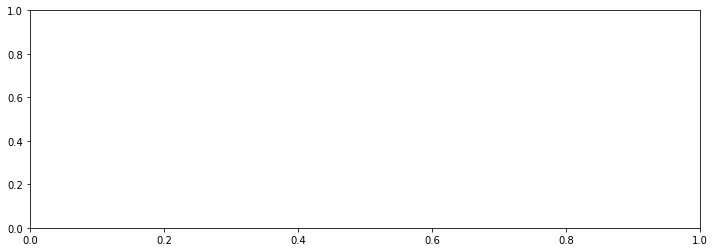

In [11]:
df.plot(x = 'TIMESTAMP', y = 'InvPDC_kW_Avg', figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('PV Power Generation [kW]')
plt.title('Time Series of PV Power Generation by Date');

In [13]:
pred = fit_predict_model(df)

C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [14]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [15]:
pred

ds     trend      yhat  yhat_lower  yhat_upper  fact  \
0    2017-01-01 00:00:00  0.000958  0.000958   -0.139843    0.145546   0.0   
1    2017-01-01 00:01:00  0.000946  0.000946   -0.139484    0.142639   0.0   
2    2017-01-01 00:02:00  0.000933  0.000933   -0.143765    0.146296   0.0   
3    2017-01-01 00:03:00  0.000920  0.000920   -0.140014    0.126402   0.0   
4    2017-01-01 00:04:00  0.000907  0.000907   -0.135698    0.151112   0.0   
5    2017-01-01 00:05:00  0.000894  0.000894   -0.154458    0.141979   0.0   
6    2017-01-01 00:06:00  0.000881  0.000881   -0.137368    0.149124   0.0   
7    2017-01-01 00:07:00  0.000869  0.000869   -0.135553    0.144320   0.0   
8    2017-01-01 00:08:00  0.000856  0.000856   -0.151096    0.146628   0.0   
9    2017-01-01 00:09:00  0.000843  0.000843   -0.131193    0.127631   0.0   
10   2017-01-01 00:10:00  0.000830  0.000830   -0.141482    0.143007   0.0   
11   2017-01-01 00:11:00  0.000817  0.000817   -0.145065    0.136455   0.0   
12   2017-01-01 00:12:00  0.000804  0.000804   -0.136068    0.145759   0.0   
13   2017-01-01 00:13:00  0.000792  0.000792   -0.147786    0.140757   0.0   
14   2017-01-01 00:14:00  0.000779  0.000779   -0.151066    0.145985   0.0   
15   2017-01-01 00:15:00  0.000766  0.000766   -0.135420    0.148662   0.0   
16   2017-01-01 00:16:00  0.000753  0.000753   -0.145557    0.142256   0.0   
17   2017-01-01 00:17:00  0.000740  0.000740   -0.139949    0.125152   0.0   
18   2017-01-01 00:18:00  0.000728  0.000728   -0.149627    0.139141   0.0   
19   2017-01-01 00:19:00  0.000715  0.000715   -0.140621    0.148956   0.0   
20   2017-01-01 00:20:00  0.000702  0.000702   -0.137607    0.131948   0.0   
21   2017-01-01 00:21:00  0.000689  0.000689   -0.147070    0.139217   0.0   
22   2017-01-01 00:22:00  0.000676  0.000676   -0.127546    0.139436   0.0   
23   2017-01-01 00:23:00  0.000663  0.000663   -0.141357    0.135194   0.0   
24   2017-01-01 00:24:00  0.000651  0.000651   -0.145413    0.139067   0.0   
25   2017-01-01 00:25:00  0.000638  0.000638   -0.145020    0.147110   0.0   
26   2017-01-01 00:26:00  0.000625  0.000625   -0.135117    0.144185   0.0   
27   2017-01-01 00:27:00  0.000612  0.000612   -0.136515    0.144039   0.0   
28   2017-01-01 00:28:00  0.000599  0.000599   -0.149667    0.132228   0.0   
29   2017-01-01 00:29:00  0.000586  0.000586   -0.150559    0.132915   0.0   
...                  ...       ...       ...         ...         ...   ...   
1411 2017-01-01 23:31:00 -0.000176 -0.000176   -0.146736    0.143662   0.0   
1412 2017-01-01 23:32:00 -0.000165 -0.000165   -0.122892    0.134100   0.0   
1413 2017-01-01 23:33:00 -0.000154 -0.000154   -0.135929    0.122147   0.0   
1414 2017-01-01 23:34:00 -0.000142 -0.000142   -0.131817    0.146085   0.0   
1415 2017-01-01 23:35:00 -0.000131 -0.000131   -0.156190    0.142283   0.0   
1416 2017-01-01 23:36:00 -0.000120 -0.000120   -0.133781    0.153705   0.0   
1417 2017-01-01 23:37:00 -0.000108 -0.000108   -0.132276    0.147615   0.0   
1418 2017-01-01 23:38:00 -0.000097 -0.000097   -0.133820    0.154372   0.0   
1419 2017-01-01 23:39:00 -0.000086 -0.000086   -0.139268    0.129059   0.0   
1420 2017-01-01 23:40:00 -0.000074 -0.000074   -0.141605    0.139107   0.0   
1421 2017-01-01 23:41:00 -0.000063 -0.000063   -0.151399    0.150611   0.0   
1422 2017-01-01 23:42:00 -0.000052 -0.000052   -0.141507    0.139617   0.0   
1423 2017-01-01 23:43:00 -0.000040 -0.000040   -0.127751    0.147410   0.0   
1424 2017-01-01 23:44:00 -0.000029 -0.000029   -0.147238    0.134258   0.0   
1425 2017-01-01 23:45:00 -0.000018 -0.000018   -0.152340    0.167992   0.0   
1426 2017-01-01 23:46:00 -0.000006 -0.000006   -0.168292    0.137954   0.0   
1427 2017-01-01 23:47:00  0.000005  0.000005   -0.161240    0.147274   0.0   
1428 2017-01-01 23:48:00  0.000016  0.000016   -0.152430    0.143579   0.0   
1429 2017-01-01 23:49:00  0.000028  0.000028   -0.147241    0.152705   0.0   
1430 2017-01-01 23:50:00  0.000039  0.000039

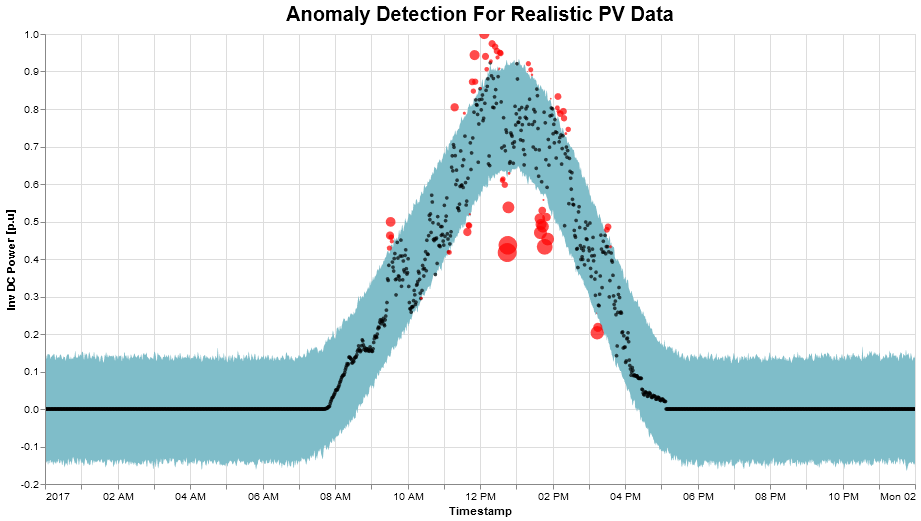

In [17]:
def plot_anomalies(forecasted):
    alt.renderers.enable('notebook')
    alt.data_transformers.disable_max_rows()
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FBDC9').encode(
    x=alt.X('ds:T',  title ='Timestamp'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection For Realistic PV Data'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Inv DC Power [p.u]'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Inv DC Power [p.u]'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

plot_anomalies(pred)